In [24]:
import numpy as np
import scipy
from skimage import morphology, feature
import cv2 as cv
from math import ceil
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

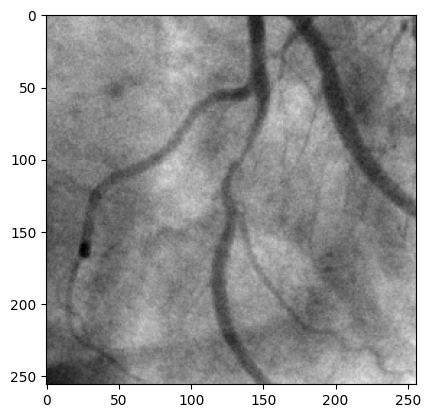

In [25]:
img = cv.imread('ang2.png', cv.IMREAD_GRAYSCALE)

# convert image to float
img = np.float32(img) / 255.0

plt.imshow(img, cmap='gray')
plt.show()

In [26]:
# from https://stackoverflow.com/a/46892763
def gkern(sigma=5, kernlen=None):
    """Returns a 2D Gaussian kernel array."""
    kernlen = kernlen or (2*ceil(4*sigma)+1) # pdf = 0.95
    gkern1d = scipy.signal.windows.gaussian(kernlen, std=sigma).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

In [27]:
# From lecture notes
def psf2otf(psf, shape):
  M, N = shape
  # get size of psf
  sz = np.shape(psf)
  # calculate needed paddings
  n = N - sz[1]
  m = M - sz[0]
  n1 = int(np.floor(n / 2) + np.mod(n, 2))
  n2 = int(np.floor(n / 2))
  m1 = int(np.floor(m / 2) + np.mod(m, 2))
  m2 = int(np.floor(m / 2))
  # pad array with zeros
  psf = np.pad(psf, ((m1, m2), (n1, n2)))
  # shift origin
  psf = np.fft.ifftshift(psf)
  # apply DFT
  otf = np.fft.fft2(psf)
  return otf

In [28]:
# Based on from https://docs.opencv.org/4.x/de/dbc/tutorial_py_fourier_transform.html
def fft2(img):
  dft = np.fft.fft2(img)
  dft_shift = np.fft.fftshift(dft)
  magnitude_spectrum = 20*np.log(np.abs(dft_shift))

  return dft_shift, magnitude_spectrum

def ifft2(dft_shift):
    dft = np.fft.ifftshift(dft_shift)
    idft = np.fft.ifft2(dft)
    img_back = np.abs(idft)

    return img_back

## Question 1

In [29]:
def plot_psf_3d(psf, title = None):
    kernlen = psf.shape[0]

    x = np.linspace(-kernlen/2, kernlen/2, kernlen)
    y = np.linspace(-kernlen/2, kernlen/2, kernlen)

    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, psf, cmap=matplotlib.cm.coolwarm,
                        linewidth=0, antialiased=False)

    fig.colorbar(surf, shrink=0.5, aspect=5)

    if title is not None:
        ax.set_title(title)

    plt.show()

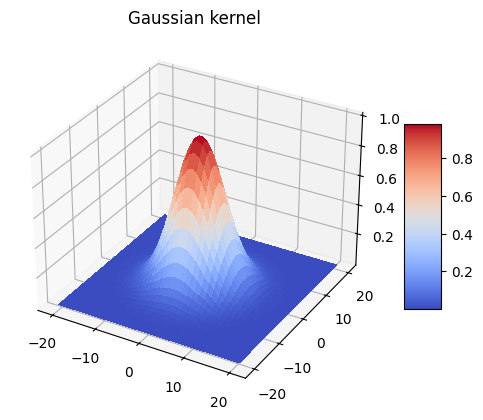

In [30]:
psf = gkern(5)
plot_psf_3d(psf, 'Gaussian kernel')

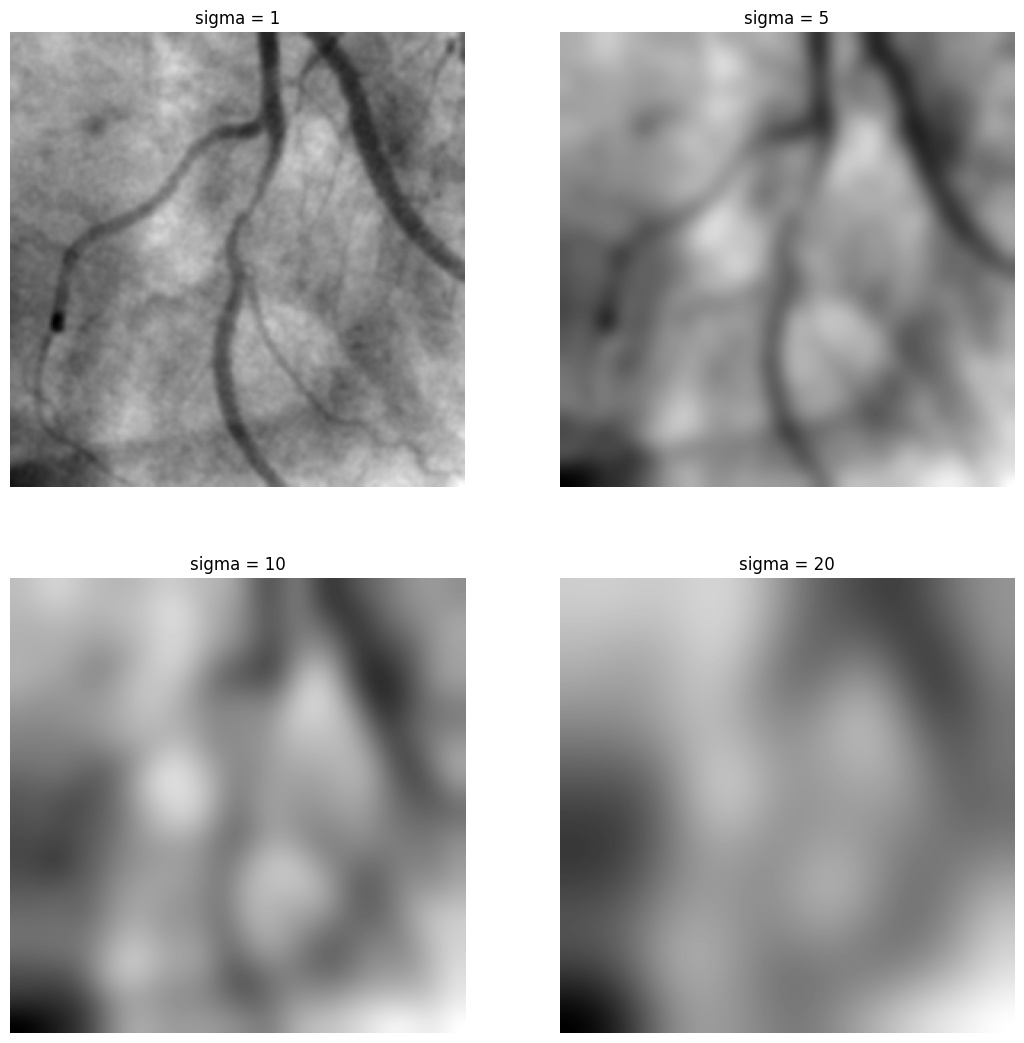

In [31]:
sigma = [1, 5, 10, 20]

fig, axs = plt.subplots(2, 2, figsize=(13, 13))
for i, s in enumerate(sigma):
    psf = gkern(s)
    img_blur = cv.filter2D(img, -1, psf)
    
    ax = axs[i//2, i%2]
    ax.imshow(img_blur, cmap='gray')
    ax.set_title(f'sigma = {s}')
    ax.axis('off')

In [32]:
dx = np.array([[1, 0, -1]])
dy = dx.T

max real: 0.0
max imag: 2.0


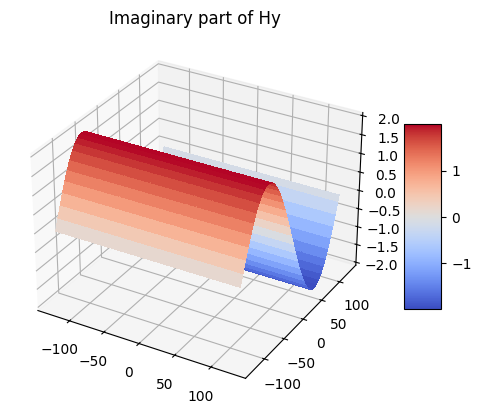

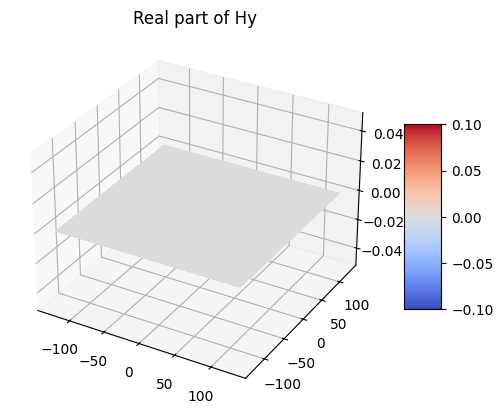

In [33]:
psf = gkern(8)
otf = psf2otf(dy, img.shape)

print(f"max real: {np.max(otf.real)}")
print(f"max imag: {np.max(otf.imag)}")

mtf = np.abs(otf)

plot_psf_3d(otf.imag, 'Imaginary part of Hy')
plot_psf_3d(otf.real, 'Real part of Hy')

plt.show()

Text(0.5, 1.0, 'Apply Hy in frequency domain')

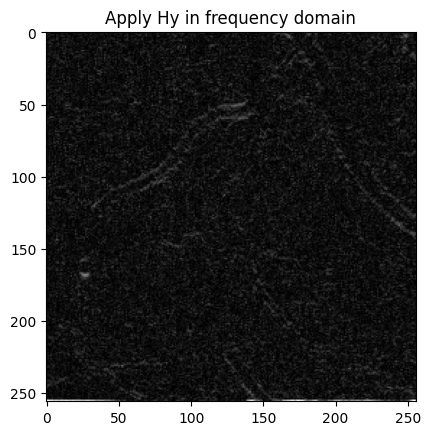

In [34]:
psf = gkern(7)
otf = psf2otf(dy, img.shape)

img_dft, img_dft_mag = fft2(img)
dft = img_dft.copy() * otf
img_back = ifft2(dft)

plt.imshow(img_back, cmap='gray')
plt.title('Apply Hy in frequency domain')

# Question 3

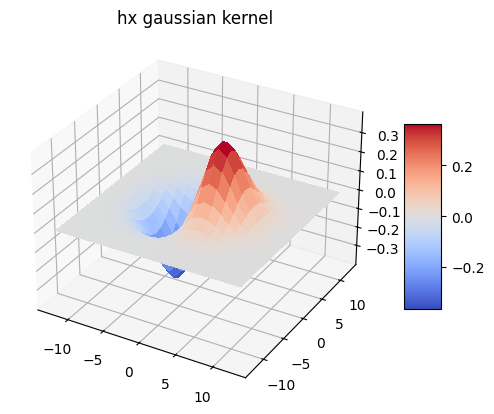

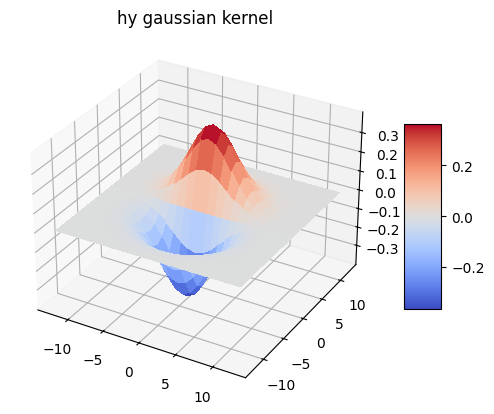

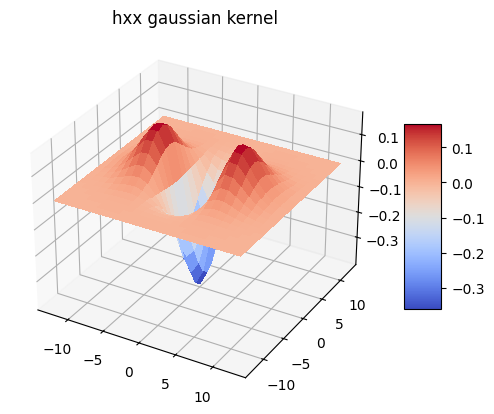

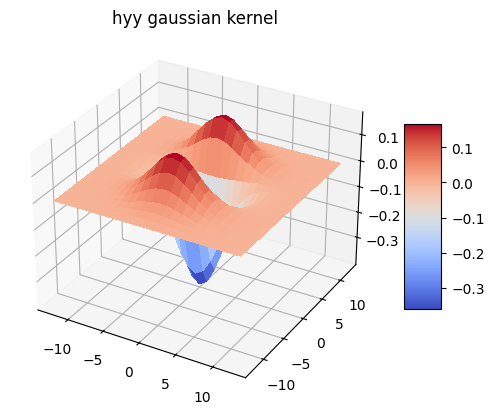

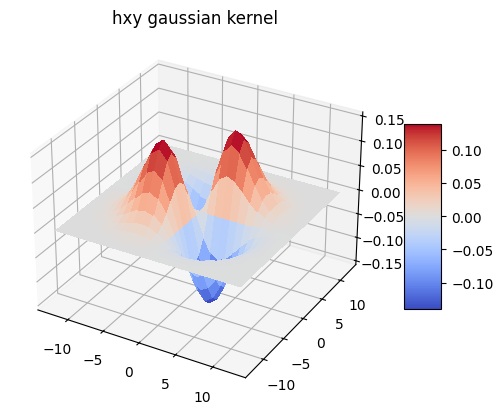

In [35]:

psf = gkern(3)
psf_dx = cv.filter2D(psf, -1, dx)
psf_dy = cv.filter2D(psf, -1, dy)

psf_dxx = cv.filter2D(psf_dx, -1, dx)
psf_dyy = cv.filter2D(psf_dy, -1, dy)
psf_dxy = cv.filter2D(psf_dx, -1, dy)

plot_psf_3d(psf_dx, 'hx gaussian kernel')
plot_psf_3d(psf_dy, 'hy gaussian kernel')
plot_psf_3d(psf_dxx, 'hxx gaussian kernel')
plot_psf_3d(psf_dyy, 'hyy gaussian kernel')
plot_psf_3d(psf_dxy, 'hxy gaussian kernel')

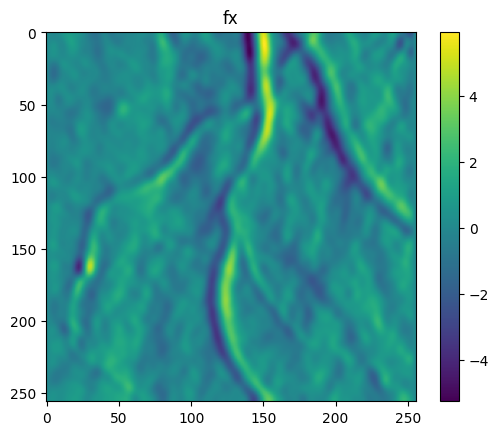

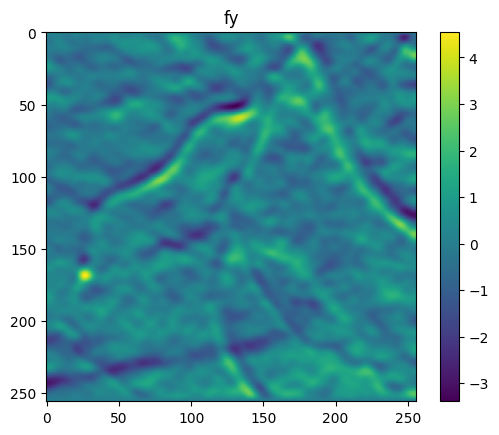

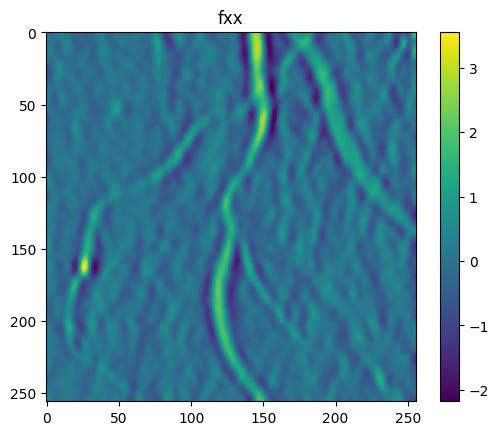

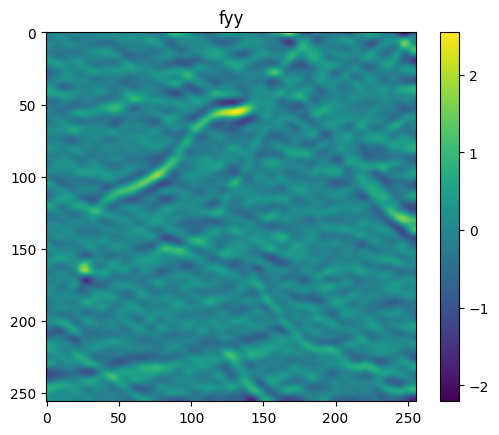

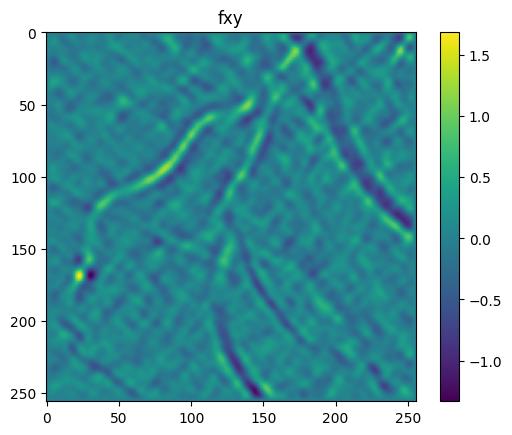

In [36]:
img_dx = cv.filter2D(img, -1, psf_dx)
img_dy = cv.filter2D(img, -1, psf_dy)
img_dxx = cv.filter2D(img, -1, psf_dxx)
img_dyy = cv.filter2D(img, -1, psf_dyy)
img_dxy = cv.filter2D(img, -1, psf_dxy)

def plot_img(img, title):
    plt.imshow(img)
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_img(img_dx, 'fx')
plot_img(img_dy, 'fy')
plot_img(img_dxx, 'fxx')
plot_img(img_dyy, 'fyy')
plot_img(img_dxy, 'fxy')

## Question 4

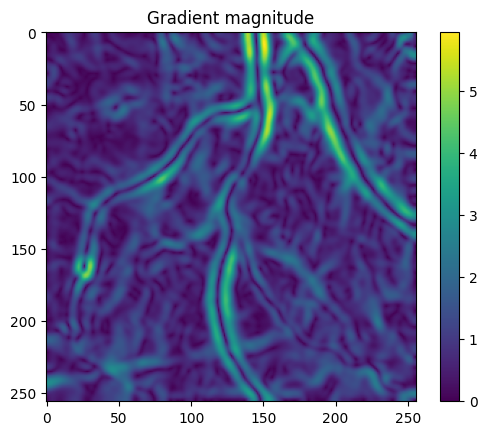

In [37]:
# Gradient magnitude
img_grad = np.sqrt(img_dx**2 + img_dy**2)

plt.imshow(img_grad)

plt.title('Gradient magnitude')
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Laplacian')

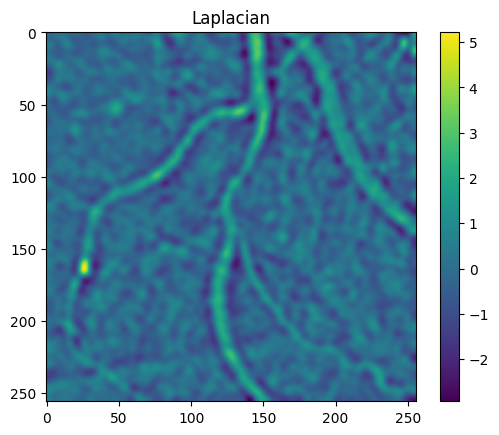

In [38]:
# Laplacian
img_lap = img_dxx + img_dyy

plt.imshow(img_lap)
plt.colorbar()
plt.title('Laplacian')

# Question 5

Text(0.5, 1.0, 'Thresholded Laplacian')

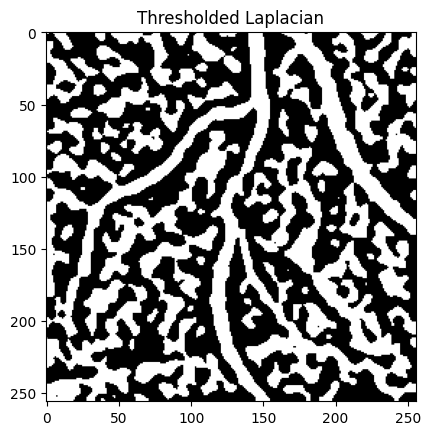

In [39]:
img_lap_thresholded = img_lap > 0

plt.imshow(img_lap_thresholded, cmap='gray')
plt.title('Thresholded Laplacian')

Text(0.5, 1.0, 'Zero crossings')

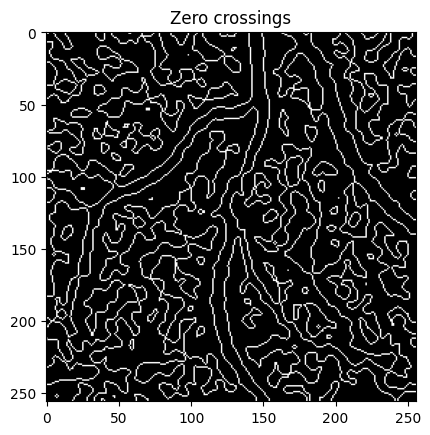

In [40]:
struct = morphology.diamond(1)
eroded = morphology.binary_erosion(img_lap_thresholded, struct)
img_lab_zero_crossings = img_lap_thresholded ^ eroded

plt.imshow(img_lab_zero_crossings, cmap='gray')
plt.title('Zero crossings')

Text(0.5, 1.0, 'Marr-Hildreth')

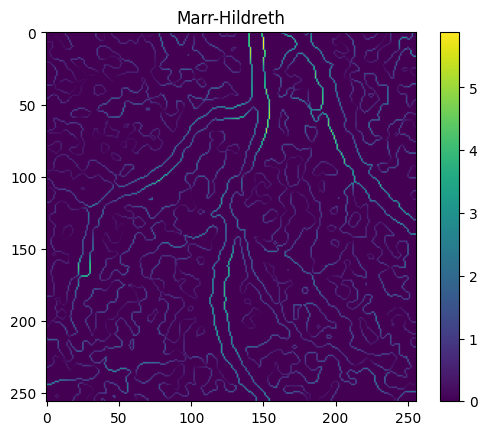

In [41]:
# Marr-Hildreth

img_grad_zero_crossings = img_grad * img_lab_zero_crossings

plt.imshow(img_grad_zero_crossings)
plt.colorbar()
plt.title('Marr-Hildreth')

1.1920780181884767


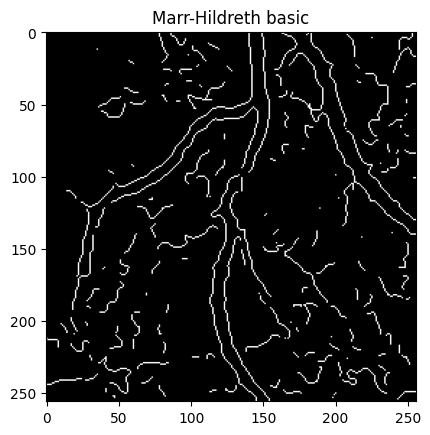

In [42]:
img_max = img_grad.max()
threshold_basic = img_max*0.2

print(threshold_basic)
img_marr_hildreth_basic = img_grad_zero_crossings > threshold_basic

plt.imshow(img_marr_hildreth_basic, cmap='gray')
plt.title('Marr-Hildreth basic')
plt.show()

0.5960390090942383 2.9801950454711914


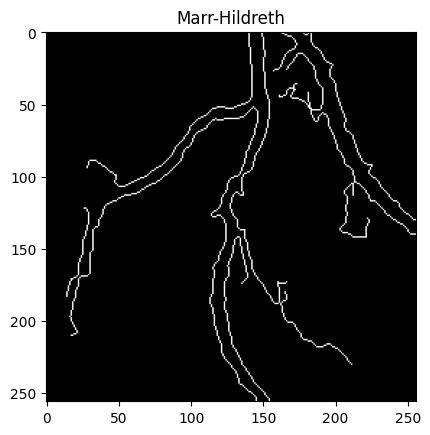

In [43]:
low_threshold = img_max*0.1
high_threshold = img_max*0.5
print(low_threshold, high_threshold)

img_marr_hildreth_marker = img_grad_zero_crossings > high_threshold
img_marr_hildreth_mask = img_grad_zero_crossings > low_threshold

img_marr_hildreth_thresholded = morphology.reconstruction(img_marr_hildreth_marker, img_marr_hildreth_mask)

plt.imshow(img_marr_hildreth_thresholded, cmap='gray')
plt.title('Marr-Hildreth')
plt.show()

# Question 7

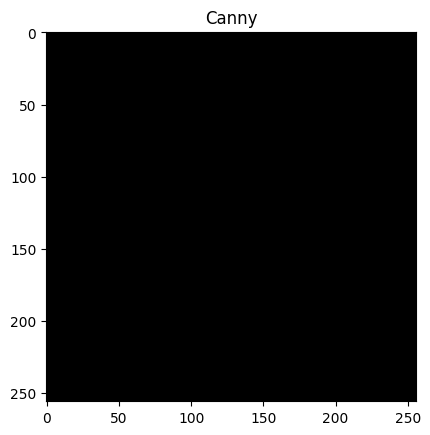

In [44]:
img_canny = feature.canny(img, sigma=3, low_threshold=low_threshold, high_threshold=high_threshold)

plt.imshow(img_canny, cmap='gray')
plt.title('Canny')
plt.show()

In [45]:
from ut_functions import levelx